In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LoadImaged,
    LabelToMaskd,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    RepeatChanneld,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    SplitChanneld,
    ThresholdIntensityd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import sys

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [2]:
img1_dir = "../../Data/VFoldData/ROIData/"

all_images1 = sorted(glob(os.path.join(img1_dir, '*.roi.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.roi.extruded-overlay-NS.nii.gz')))

for i in range(len(all_images1)):
    img1 = itk.imread(all_images1[i])
    lbl = itk.imread(all_labels[i])
    if img1.shape != lbl.shape:
        print( lbl.shape, img1.shape)
        print("Error1")


In [3]:
img1_dir = "../../Data/VFoldData/ROIData/"

all_images = sorted(glob(os.path.join(img1_dir, '*.roi.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.roi.extruded-overlay-NS.nii.gz')))

gpu_device = 0
num_gpu_devices = 1
#if len(sys.argv)==3:
    #gpu_device = int(sys.argv[1])
    #num_gpu_devices = int(sys.argv[2])
    
num_classes = 3

net_channels = (24, 32, 64, 128)
net_strides = (2, 2, 2)

num_folds = 15

num_slices = 48
size_x = 128
size_y = 224

roi_size = (size_x,size_y,num_slices)

num_workers_tr = 1
batch_size_tr = 24
num_workers_vl = 1
batch_size_vl = 4


model_filename_base = "./results/BAMC_PTX_ROI_3DUNet-Extruded-NS.best_model.vfold"

num_images = len(all_images)
print(num_images)

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

110
96 6 8
92 8 10
93 10 7
97 7 6
96 6 8
98 8 4
100 4 6
97 6 7
98 7 5
92 5 13
92 13 5
98 5 7
93 7 10
92 10 8
96 8 6


In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=2,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keys=['image', 'label'],
            keep_size=True,
            mode=['trilinear', 'nearest']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            center_slice=30,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [5]:
img = itk.imread(train_files[0][0]["image"])
arr = itk.GetArrayFromImage(img)

In [6]:
train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=None)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=None)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

Loading dataset: 100%|████████████████████████████| 8/8 [00:00<00:00, 24.54it/s]


{'image': '../../Data/VFoldData/ROIData/221ns_image_584357289931_clean_ClassN_110-238.roi.nii.gz', 'label': '../../Data/VFoldData/ROIData/221ns_image_584357289931_clean_ClassN_110-238.roi.extruded-overlay-NS.nii.gz'}
torch.Size([4, 1, 128, 224, 48])
torch.Size([128, 224, 48])
image shape: torch.Size([128, 224, 48]), label shape: torch.Size([128, 224, 48])


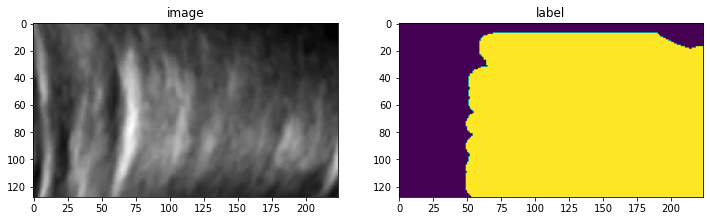

tensor(0.) tensor(1.)


In [7]:
if True: #len(sys.argv)>0:
    imgnum = 0
    check_data = first(val_loader[0])
    print(val_files[0][imgnum])
    image, label = (check_data["image"][imgnum][0], check_data["label"][imgnum][0])
    print(check_data["image"].shape)
    print(image.shape)
    print(f"image shape: {image.shape}, label shape: {label.shape}")
    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image[:, :, 2], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("label")
    plt.imshow(label[:, :, 2])
    plt.show()
    print(label.min(), label.max())

In [8]:
device = torch.device("cuda:"+str(gpu_device))

def vfold_train(vfold_num, train_loader, val_loader):
    model = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")


    max_epochs = 500
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(
                f"{step}/{len(train_ds) // train_loader.batch_size}, "
                f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, batch_size_vl, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), model_filename_base+'_'+str(vfold_num)+'.pth')
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_val_dice_"+str(vfold_num)+".npy", metric_values)

In [ ]:
for i in range(gpu_device,num_folds,num_gpu_devices):
    vfold_train(i, train_loader[i], val_loader[i])

----------
0: epoch 1/500
1/0, train_loss: 0.7398
2/0, train_loss: 0.7379
3/0, train_loss: 0.7308
4/0, train_loss: 0.7295
0 epoch 1 average loss: 0.7345
----------
0: epoch 2/500
1/0, train_loss: 0.7231
2/0, train_loss: 0.7251
3/0, train_loss: 0.7218
4/0, train_loss: 0.7227
0 epoch 2 average loss: 0.7232
saved new best metric model
current epoch: 2 current mean dice: 0.2488
best mean dice: 0.2488 at epoch: 2
----------
0: epoch 3/500
1/0, train_loss: 0.7177
2/0, train_loss: 0.7121
3/0, train_loss: 0.7114
4/0, train_loss: 0.7152
0 epoch 3 average loss: 0.7141
----------
0: epoch 4/500
1/0, train_loss: 0.7100
2/0, train_loss: 0.7036
